In [268]:
import os
import re
import json
import matplotlib.pyplot as plt
import numpy as np
import string
import pandas as pd

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor

from os import listdir
from os.path import isfile, join
from pyspark.ml.linalg import Vectors
from sklearn.metrics import mean_squared_error
from sklearn.manifold import TSNE
from itertools import chain
from scipy.sparse import coo_matrix
from pyspark.mllib.linalg.distributed import CoordinateMatrix, MatrixEntry, IndexedRow, IndexedRowMatrix
from pyspark.sql import Row
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import SGDClassifier, RidgeClassifierCV
from operator import add
from pyspark.sql.functions import udf
from pyspark.sql import SparkSession
from pyspark.sql.types import IntegerType, FloatType
from __future__ import print_function, unicode_literals, with_statement, absolute_import, generators, nested_scopes, division
from pyspark.sql.functions import mean, stddev
%matplotlib inline

In [2]:
# Local Spark
# spark session is now the entry point of spark program
# for line 8, can use local[n] for run spark locally with n cores

runLocal = True
if runLocal == True:
    spark = SparkSession.builder \
        .master('local[50]') \
        .appName("Word Count") \
        .config("spark.driver.maxResultSize", "15g")\
        .getOrCreate()
else:
    #p = subprocess.Popen(['sinteractive', '--partition=broadwl', '--cpus-per-task=10', '--time=00:30:00'], stdout=subprocess.PIPE, shell = True)
    #print(p.stdout.read())
    # start spark master program on this machine and register worker nodes
    os.system('start-spark-slurm.sh&') # use & to put it into background
    # get ip address of this machine
    ip = os.popen('hostname -i').read().strip('\n')
    # change 'local' to be ip of master node
    spark = SparkSession.builder \
        .master('spark://' + ip + ':7077') \
        .appName('Word Count') \
        .config("spark.driver.maxResultSize", "15g")\
        .getOrCreate()
    print('Spark Session web UI: http://{}:4040'.format(ip))

In [251]:
trainData = spark.read.option('header', 'true').csv('/project/cmsc25025/zillow/zillow-train.csv').dropna()
testData_ = spark.read.option('header', 'true').csv('/project/cmsc25025/zillow/zillow-test.csv').dropna()

In [4]:
trainData.show(1)

+-------+---------+----------+---------+--------+--------+-------+---------+-----------+----------+----------+-------+-------+----------+--------------------+---------+
|     ID|      Lat|      Long|ListPrice|SaleYear|Bathroom|Bedroom|BuiltYear|BuildDecade|MajorRenov|FinishSqFt|LotSqFt|    MSA|      City|          HighSchool|SalePrice|
+-------+---------+----------+---------+--------+--------+-------+---------+-----------+----------+----------+-------+-------+----------+--------------------+---------+
|3243035|42.145705|-88.138659|    99000|    2012|       2|      2|     1953|       1950|      NONE|      1020|  14344|Chicago|Barrington|Barrington High S...|    90000|
+-------+---------+----------+---------+--------+--------+-------+---------+-----------+----------+----------+-------+-------+----------+--------------------+---------+
only showing top 1 row



In [68]:
numerical_cols = ['Lat', 'Long', 'MajorRenov','ListPrice', 'SaleYear', 'Bathroom', 'Bedroom', 'BuiltYear',
'BuildDecade', 'FinishSqFt', 'LotSqFt', 'SalePrice']
cate_cols = ['MSA', 'City', 'HighSchool']

# (a) 
Explore the data to learn what the different predictor variables are, and what their distribution looks like. Make plots of these distributions. Some of the variables are categorical—how many values do they take? When you plot the variables, including the response SalePrice, does it appear that the data are “raw” or that they have been preprocessed in different ways? How?

In [28]:
trainData.describe(numerical_cols[2:7]).show()

+-------+------------------+------------------+------------------+------------------+------------------+
|summary|        MajorRenov|         ListPrice|          SaleYear|          Bathroom|           Bedroom|
+-------+------------------+------------------+------------------+------------------+------------------+
|  count|            185999|            185999|            185999|            185999|            185999|
|   mean|1996.9621991084696| 422109.2101045925| 2013.387179500965|2.3313512438238915| 3.200490325216802|
| stddev| 23.80040133233472|268237.03829118336|1.0476354926055451|0.8470899795255945|1.0397494462458778|
|    min|              1860|          1.00E+05|              2007|                 1|                 0|
|    max|              NONE|            999999|              2015|               5.5|                 7|
+-------+------------------+------------------+------------------+------------------+------------------+



In [29]:
trainData.describe(numerical_cols[7:]).show()

+-------+-----------------+------------------+------------------+-----------------+------------------+
|summary|        BuiltYear|       BuildDecade|        FinishSqFt|          LotSqFt|         SalePrice|
+-------+-----------------+------------------+------------------+-----------------+------------------+
|  count|           185999|            185999|            185999|           185999|            185999|
|   mean|1973.337904515984|1968.9945269303096|1918.3190118544771|7916.661579417607| 413089.8861481574|
| stddev|27.61004439890775| 27.41744017219692| 812.9502700920468|3652.103295316715|264045.70279259374|
|    min|             1600|              1600|                 0|                0|          1.00E+05|
|    max|               NA|           UNKNOWN|             999.5|           9999.5|            999999|
+-------+-----------------+------------------+------------------+-----------------+------------------+



In [8]:
mr = trainData.select('MajorRenov').rdd.flatMap(lambda x: x).collect()
sy = trainData.select('SaleYear').rdd.flatMap(lambda x: x).collect()
lp = trainData.select('ListPrice').rdd.flatMap(lambda x: x).collect()
bath = trainData.select('Bathroom').rdd.flatMap(lambda x: x).collect()
bed = trainData.select('Bedroom').rdd.flatMap(lambda x: x).collect()
bd = trainData.select('BuildDecade').rdd.flatMap(lambda x: x).collect()
fs = trainData.select('FinishSqFt').rdd.flatMap(lambda x: x).collect()
ls = trainData.select('LotSqFt').rdd.flatMap(lambda x: x).collect()
by = trainData.select('BuiltYear').rdd.flatMap(lambda x: x).collect()
sp = trainData.select('SalePrice').rdd.flatMap(lambda x: x).collect()

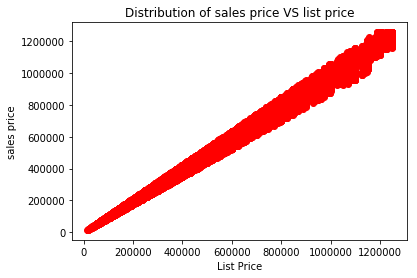

In [9]:
plt.plot(lp,sp, 'ro')
plt.title('Distribution of sales price VS list price')
plt.xlabel('List Price')
plt.ylabel('sales price')
plt.show()

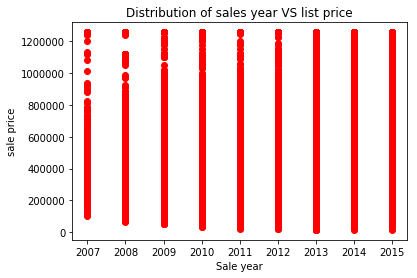

In [10]:
plt.plot(sy,sp, 'ro')
plt.title('Distribution of sales year VS list price')
plt.xlabel('Sale year')
plt.ylabel('sale price')

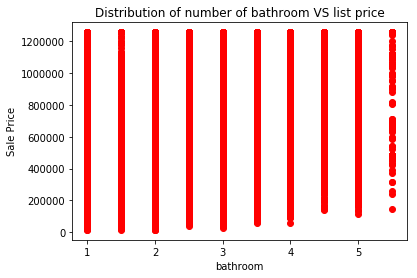

In [11]:
plt.plot(bath,sp, 'ro')
plt.title('Distribution of number of bathroom VS list price')
plt.xlabel('bathroom')
plt.ylabel('Sale Price')

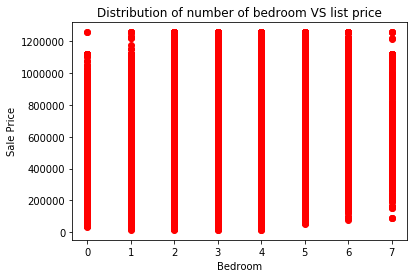

In [12]:
plt.plot(bed,sp, 'ro')
plt.title('Distribution of number of bedroom VS list price')
plt.xlabel('Bedroom')
plt.ylabel('Sale Price')

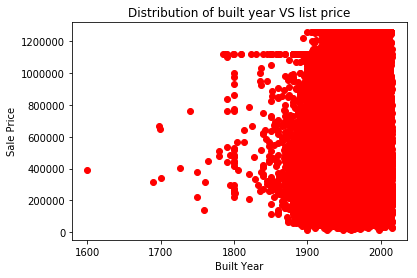

In [13]:
d = {'by': by, 'sp': sp}
df = pd.DataFrame(d)
df = df[df.by != 'NA']

plt.plot(df.by,df.sp, 'ro')
plt.title('Distribution of built year VS list price')
plt.xlabel('Built Year')
plt.ylabel('Sale Price')

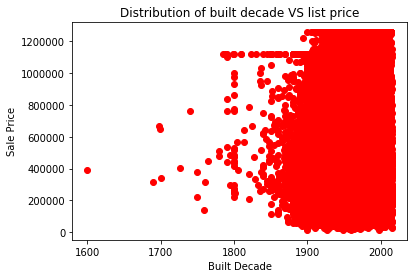

In [15]:
d = {'bd': by, 'sp': sp}
df = pd.DataFrame(d)
df = df[df.bd != 'NA']

plt.plot(df.bd,df.sp, 'ro')
plt.title('Distribution of built decade VS list price')
plt.xlabel('Built Decade')
plt.ylabel('Sale Price')

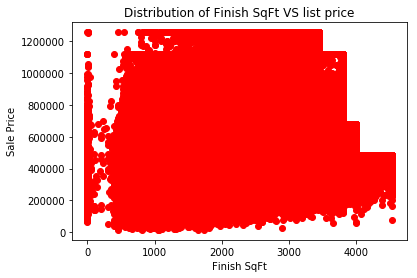

In [16]:
plt.plot(fs,sp, 'ro')
plt.title('Distribution of Finish SqFt VS list price')
plt.xlabel('Finish SqFt')
plt.ylabel('Sale Price')

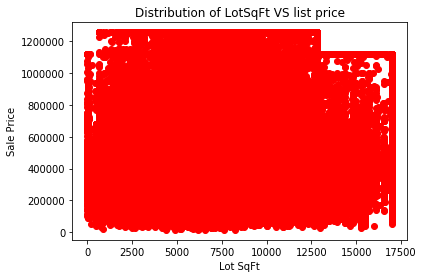

In [17]:
plt.plot(ls,sp, 'ro')
plt.title('Distribution of LotSqFt VS list price')
plt.xlabel('Lot SqFt')
plt.ylabel('Sale Price')

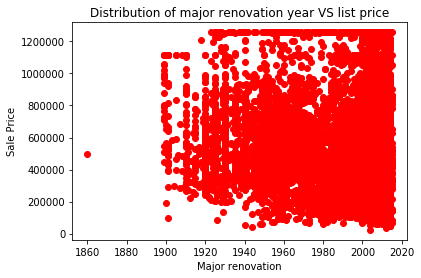

In [25]:
d = {'mr': mr, 'sp': sp}
df = pd.DataFrame(d)
df = df[df.mr != 'NONE']

plt.plot(df.mr,df.sp, 'ro')
plt.title('Distribution of major renovation year VS list price')
plt.xlabel('Major renovation')
plt.ylabel('Sale Price')

For numerical variables, we could observe their distribution from summary statistics and get an idea of their effects on the sale price. Through observing these scatter plots, we could realize that there are sharp changes in y values for both Finish sqft and Lot sqft. This may indicate that these two variables have been preprocessed.

In [21]:
msa = trainData.select('MSA').rdd.flatMap(lambda x: x).collect()
c = trainData.select('City').rdd.flatMap(lambda x: x).collect()
hs = trainData.select('HighSchool').rdd.flatMap(lambda x: x).collect()

In [44]:
d = {'msa': msa, 'sp': [float(x) for x in sp]}
df = pd.DataFrame(d).groupby(['msa']).mean()
print('Number of distinct values:', len(df))
df.sort_values(by = 'sp',ascending = False)

Number of distinct values: 4


,sp
msa,
Los Angeles,593136.685402
New York City,481713.603733
Chicago,303921.825395
Dallas,218378.397395


In [233]:
d_ = {'c': c, 'sp': [float(x) for x in sp]}
df_ = pd.DataFrame(d_).groupby(['c']).mean()
print('Number of distinct values:', len(df))
df_.sort_values(by = 'sp',ascending = False)

Number of distinct values: 669


,sp
c,
Rolling Hills,1.257245e+06
Hidden Hills,1.257245e+06
San Marino,1.240516e+06
Manhattan Beach,1.182741e+06
Palos Verdes Estates,1.176108e+06
Newport Coast,1.165134e+06
Malibu,1.149637e+06
Laguna Beach,1.129763e+06
Quogue,1.117880e+06


In [46]:
d = {'hs': hs, 'sp': [float(x) for x in sp]}
df = pd.DataFrame(d).groupby(['hs']).mean()
print('Number of distinct values:', len(df))
df.sort_values(by = 'sp',ascending = False)

Number of distinct values: 669


,sp
hs,
San Marino High School,1.234213e+06
Palisades Charter High School,1.205646e+06
Mira Costa High School,1.183245e+06
Malibu High School,1.150812e+06
La Canada High School,1.119675e+06
Corona Del Mar High School,1.092364e+06
Bridgehampton School,1.033940e+06
Serrano High School,1.016283e+06
Venice Senior High School,9.660435e+05


For categorical variables, we could observe the number of distinct values and the average sales price against different values of the variables.

# (b)
Build random forest models to predict SalePrice from the other covariates.

First, convert categorical values to numerical labels.

In [51]:
le_msa = preprocessing.LabelEncoder()
msa_l =le_msa.fit_transform(msa)

le_c = preprocessing.LabelEncoder()
c_l =le_c.fit_transform(c)

le_hs = preprocessing.LabelEncoder()
hs_l =le_hs.fit_transform(hs)

In [186]:
trainDF = trainData.toPandas()

## First attempt: 
- convert categorical data to labels
- remove original categorical variables
- remove 'MajorRenov', 'ID', 'Lat', 'Long'
- change None/NA values of builtyear and builtdecade to 0

In [188]:
trainDF_1 = trainDF.drop(cate_cols+['MajorRenov', 'ID', 'Lat', 'Long'], 1)
trainDF_1['msa_l'] = msa_l
trainDF_1['c_l'] = c_l
trainDF_1['hs_l'] = hs_l
trainDF_1['BuiltYear'] = trainDF_1['BuiltYear'].apply(lambda x: 0 if x== 'NA' else x)
trainDF_1['BuildDecade'] = trainDF_1['BuildDecade'].apply(lambda x: 0 if x.isdigit()== False else x)

In [80]:
# Split the data into training and test sets (30% held out for testing)
train, test = train_test_split(trainDF_1, test_size = 0.3)

In [122]:
y_train = list(train['SalePrice'].apply(lambda x: float(x)))
y_test = list(test['SalePrice'].apply(lambda x: float(x)))

In [139]:
l = list(np.arange(8))+[9,10,11]
X_train = train[l]
X_test = test[l]

In [124]:
clf_1 = RandomForestRegressor(max_depth= 30, random_state=0)
clf_1.fit(X_train, y_train)
y_predict = clf_1.predict(X_test)

In [125]:
mean_squared_error(y_test, y_predict)

188554945.45078951

In [267]:
mean_absolute_error(y_test, y_predict)

9011.259513808729

## Second attempt: 
- convert categorical data to labels
- remove original categorical variables
- remove 'MajorRenov', 'ID', 'Lat', 'Long'
- remove builtyear and builtdecade

In [126]:
X_train_2 = X_train.drop(['BuiltYear', 'BuildDecade'], 1)
X_test_2 = X_test.drop(['BuiltYear', 'BuildDecade'], 1)

In [130]:
clf_2 = RandomForestRegressor(max_depth= 30, random_state=0)
clf_2.fit(X_train_2, y_train)
y_predict_2 = clf_2.predict(X_test_2)

In [131]:
mean_squared_error(y_test, y_predict_2)

190366535.24263892

In [266]:
mean_absolute_error(y_test, y_predict_2)

9066.5021286474803

## Third attempt: 
- only using numerical variables
- remove all the rows with missing value

In [162]:
trainDF_3 = trainDF.drop(['msa_l', 'c_l', 'hs_l'],1).loc[(trainDF['BuiltYear'] != 0)].loc[(trainDF['BuildDecade'] != 0)]

In [171]:
train_3, test_3 = train_test_split(trainDF_3, test_size = 0.3)
y_train_3 = list(train_3['SalePrice'].apply(lambda x: float(x)))
y_test_3 = list(test_3['SalePrice'].apply(lambda x: float(x)))
X_train_3 = train_3.iloc[:,:-1]
X_test_3 = test_3.iloc[:,:-1]

In [184]:
clf_3 = RandomForestRegressor(max_depth= 30, random_state=0)
clf_3.fit(X_train_3, y_train_3)
y_predict_3 = clf_3.predict(X_test_3)

In [185]:
mean_squared_error(y_test_3, y_predict_3)

205823406.80944395

In [265]:
mean_absolute_error(y_test_3, y_predict_3)

9477.4187783771285

## Fourth attempt
- convert categorical data to labels
- remove original categorical variables
- remove 'ID'
- change None/NA values of 'MajorRenov', builtyear and builtdecade to 0

In [191]:
trainDF_4 = trainDF.drop(cate_cols+['ID'], 1)

In [192]:
trainDF_4['msa_l'] = msa_l
trainDF_4['c_l'] = c_l
trainDF_4['hs_l'] = hs_l
trainDF_4['BuiltYear'] = trainDF_4['BuiltYear'].apply(lambda x: 0 if x== 'NA' else x)
trainDF_4['BuildDecade'] = trainDF_4['BuildDecade'].apply(lambda x: 0 if x.isdigit()== False else x)

In [193]:
trainDF_4['MajorRenov' ] = trainDF_4['MajorRenov' ].apply(lambda x: 0 if x.isdigit()== False else x)

In [194]:
train_4, test_4 = train_test_split(trainDF_4, test_size = 0.3)

In [223]:
y_train_4 = list(train_4['SalePrice'].apply(lambda x: float(x)))
y_test_4 = list(test_4['SalePrice'].apply(lambda x: float(x)))

In [205]:
l = list(np.arange(11))+[12,13,14]
X_train_4 = train_4[l]
X_test_4 = test_4[l]

In [206]:
clf_4 = RandomForestRegressor(max_depth= 30, random_state=0)
clf_4.fit(X_train_4, y_train_4)
y_predict_4 = clf_4.predict(X_test_4)
mean_squared_error(y_test_4, y_predict_4)

182341555.5115681

In [264]:
mean_absolute_error(y_test_4, y_predict_4)

8903.1081355505557

After comparing all attempts, the last one gives us the smallest mean squared error, so we'll use this classifier to predict sales prices.

This one works the best because it uses the largest number of variables. I dropped 'Lat' and 'Long' of the observations because I thought that the city variable already provides us with significant information, but apparently the precise information on the location of the properties is very crucial. Besides, I didn't think that majorrenovation would help because there are many missing data; however, it appears that despite the number of missing values, it's still very helpful.

## Fifth attempt
Since there are cities that are not in our training set from previous data set, I'm trying to see if there will be much difference if we do not use that variable.

In [227]:
X_test_5 = X_train_4.drop('c_l',1)
X_test_5 = X_test_4.drop('c_l',1)

In [228]:
clf_5 = RandomForestRegressor(max_depth= 30, random_state=0)
clf_5.fit(X_train_5, y_train_4)
y_predict_5 = clf_5.predict(X_test_5)
mean_squared_error(y_test_4, y_predict_5)

182811291.56565523

In [262]:
mean_absolute_error(y_test_4, y_predict_5)

8917.5251589702038

# (c)
Finally,using your best regression model,predict the sale prices for the houses given

In [252]:
testDF = testData_.toPandas()
testDF_ = testDF

In [214]:
msa_l_t = le_msa.transform(list(testDF['MSA']))
#c_l_t =le_c.transform(list(testDF['City']))
hs_l_t =le_hs.transform(list(testDF['HighSchool']))

Due to cites ('Grand View-on-Hudson', 'Virgil') that's not in our training set, our previous label encoder for city variabe does not work. We have to do it by hand and give new labels to the new cities.

In [240]:
orig_c = list(df_.index)
city_l = le_c.transform(orig_c)

d ={'City': orig_c, 'labe': city_l}
d['Grand View-on-Hudson'] = 1344
d['Virgil'] = 1345

In [242]:
def add_label(x):
    try:
        return int(d[x])
    except:
        v = len(d)
        d[x] = v
        return v

In [243]:
c_l_t = list(testDF['City'].apply(lambda x: add_label(x)))

In [244]:
testDF = testDF.drop(cate_cols+['ID'], 1)

In [245]:
testDF['msa_l'] = msa_l_t
testDF['c_l'] = c_l_t
testDF['hs_l'] = hs_l_t
testDF['BuiltYear'] = testDF['BuiltYear'].apply(lambda x: 0 if x== 'NA' else x)
testDF['BuildDecade'] = testDF['BuildDecade'].apply(lambda x: 0 if x.isdigit()== False else x)
testDF['MajorRenov' ] = testDF['MajorRenov' ].apply(lambda x: 0 if x.isdigit()== False else x)

In [247]:
test_X = testDF.drop('SalePrice',1)
predict_Y = clf_4.predict(test_X)
testDF_['SalePrice'] = predict_Y
testDF_.to_csv('assn6_prob3_predict.csv')